## Retrieval

In [1]:
import pandas as pd
import torch
import numpy as np
from datasets import Dataset

from sentence_transformers import SentenceTransformer
model = SentenceTransformer("Snowflake/snowflake-arctic-embed-m-v2.0", trust_remote_code=True)
device = torch.device("cuda")
model.to(device)

print(torch.cuda.is_available())
print(next(model.parameters()).device)

Override attn_implementation='sdpa' to 'eager' as use_memory_efficient_attention='true'


True
cuda:0


In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
"""
df_examples = pd.read_parquet('shopping_queries_dataset/shopping_queries_dataset_examples.parquet')
df_products = pd.read_parquet('shopping_queries_dataset/shopping_queries_dataset_products.parquet')
#df_sources = pd.read_csv("shopping_queries_dataset/shopping_queries_dataset_sources.csv")

products = Dataset.from_pandas(df_products)
examples = Dataset.from_pandas(df_examples)

SMALL = False
products_ds = products.filter(lambda example: example['product_locale'] == "us")

examples_ds = examples.filter(lambda example: example['small_version'] == 1) #det här händer ju inte ens
examples_ds = examples.filter(lambda example: example['product_locale'] == "us")

if SMALL == True:
    train_split, products_ds = products_ds.train_test_split(test_size=0.01, seed=42).values()

from html.parser import HTMLParser

class HTMLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.text = []

    def handle_data(self, data):
        self.text.append(data)

    def get_text(self):
        return " ".join(self.text).strip()

def strip_html(text):
    if text is None:
        return ""
    stripper = HTMLStripper()
    stripper.feed(text)
    return stripper.get_text()

def concatenate_fields(example):
    fields = [example["product_title"], example["product_color"], example["product_brand"], example["product_description"]]
    filtered_fields = [strip_html(f) for f in fields if f]  # Remove HTML and None values
    example["combined_text"] = " ".join(filtered_fields).strip()
    return example

products_ds = products_ds.map(concatenate_fields)

cols_to_remove = products_ds.column_names
cols_to_remove.remove("product_id")
cols_to_remove.remove("combined_text")
corpus_ds = products_ds.remove_columns(cols_to_remove)

examples_ds = examples_ds.remove_columns("small_version")
examples_ds = examples_ds.remove_columns("large_version")
examples_ds = examples_ds.remove_columns("__index_level_0__")

examples_rel = examples_ds.filter(lambda example: example['esci_label'] == "E")
examples_rel = examples_rel.remove_columns("esci_label")
examples_rel = examples_rel.remove_columns("example_id")
examples_rel= examples_rel.remove_columns("product_locale")
qrel_ds = examples_rel.remove_columns("query")

query_ds = examples_rel.remove_columns("product_id")

seen = set()
query_ds = query_ds.filter(lambda example: example["query_id"] not in seen and not seen.add(example["query_id"]))

corpus_product_ids = set(products_ds['product_id'])

# REMOVE QUERIES WITH NO PRODUCTS
qrel_ds = qrel_ds.filter(lambda example: example['product_id'] in corpus_product_ids)
valid_query_ids = set(qrel_ds['query_id'])
query_ds = query_ds.filter(lambda example: example['query_id'] in valid_query_ids)

# SPLITS
qrel_train = qrel_ds.filter(lambda example: example['split'] == "train")
query_train = query_ds.filter(lambda example: example['split'] == "train")

qrel_test = qrel_ds.filter(lambda example: example['split'] == "test")
query_test = query_ds.filter(lambda example: example['split'] == "test")

qrel_train.save_to_disk("qrel_train")
query_train.save_to_disk("query_train")
qrel_test.save_to_disk("qrel_test")
query_test.save_to_disk("query_test")
corpus_ds.save_to_disk("corpus_ds") 
"""

'\ndf_examples = pd.read_parquet(\'shopping_queries_dataset/shopping_queries_dataset_examples.parquet\')\ndf_products = pd.read_parquet(\'shopping_queries_dataset/shopping_queries_dataset_products.parquet\')\n#df_sources = pd.read_csv("shopping_queries_dataset/shopping_queries_dataset_sources.csv")\n\nproducts = Dataset.from_pandas(df_products)\nexamples = Dataset.from_pandas(df_examples)\n\nSMALL = False\nproducts_ds = products.filter(lambda example: example[\'product_locale\'] == "us")\n\nexamples_ds = examples.filter(lambda example: example[\'small_version\'] == 1) #det här händer ju inte ens\nexamples_ds = examples.filter(lambda example: example[\'product_locale\'] == "us")\n\nif SMALL == True:\n    train_split, products_ds = products_ds.train_test_split(test_size=0.01, seed=42).values()\n\nfrom html.parser import HTMLParser\n\nclass HTMLStripper(HTMLParser):\n    def __init__(self):\n        super().__init__()\n        self.text = []\n\n    def handle_data(self, data):\n        se

In [5]:

from datasets import Dataset
from datasets import load_from_disk

qrel_train = load_from_disk("qrel_train")
query_train = load_from_disk("query_train")
qrel_test = load_from_disk("qrel_test")
query_test = load_from_disk("query_test")
corpus_ds = load_from_disk("corpus_ds")

In [ ]:
"""
query_embeddings = model.encode(query_test["query"], prompt_name="query", show_progress_bar=True)
query_embeds = np.array(query_embeddings)
np.save("query_test_embeds.npy", query_embeds)

query_embeddings_2 = model.encode(query_train["query"], prompt_name="query", show_progress_bar=True)
query_embeds_2 = np.array(query_embeddings_2)
np.save("query_train_embeds.npy", query_embeds_2)

document_embeddings = model.encode(corpus_ds["combined_text"], show_progress_bar=True)
doc_embeds = np.array(document_embeddings)
np.save('doc_embeds.npy', doc_embeds)"""

"""
query_embeddings_test = np.load('embeddings/query_test_embeds.npy')
query_embeddings_train = np.load("embeddings/query_train_embeds.npy")
document_embeddings = np.load('embeddings/doc_embeds.npy')
"""


In [ ]:
"""
import faiss # Create FAISS index (L2 normalized embeddings needed for dot product / cosine similarity)

dimension = query_embeddings_train.shape[1]
index = faiss.IndexFlatIP(dimension)  # Inner product (equivalent to cosine similarity if normalized)
faiss.normalize_L2(document_embeddings)
index.add(document_embeddings)  # Add documents to index# Normalize queries (if using cosine similarity)
faiss.normalize_L2(query_embeddings_train)# Perform search (retrieve top k similar docs per query)

k = 100  # Adjust as needed
scores, I = index.search(-1*query_embeddings_train, k)  # D = scores, I = indices of top-k docs
"""

In [ ]:
"""
I_train = np.load("faiss/faiss_index_train.npy")
scores_train = np.load("faiss/faiss_scores_train.npy")
neg_I_train = np.load("faiss/faiss_index_neg_train.npy")
neg_scores_train = np.load("faiss/faiss_scores_neg_train.npy")

I_test = np.load("faiss/faiss_index_test.npy")
scores_test = np.load("faiss/faiss_scores_test.npy")
neg_I_test = np.load("faiss/faiss_index_neg_test.npy")
neg_scores_test = np.load("faiss/faiss_scores_neg_test.npy")
"""

In [ ]:

import torch
import numpy as np
import pandas as pd
from datasets import Dataset

query_ids = query_train["query_id"]  # List of all query IDs
product_ids = corpus_ds["product_id"]  # List of all product IDs
query_ids = np.array(query_ids)
product_ids = np.array(product_ids)
k=100
scores_flat_train = scores_train.flatten()  # Convert the tensor to a flattened NumPy array
neg_scores_flat_train = neg_scores_train.flatten()
query_ids_flat = np.repeat(query_ids, k)
product_ids_flat = []
for ind in I_train.flatten():
    product_id = product_ids[ind]
    product_ids_flat.append(product_id)
flattened_scores_train = pd.DataFrame({
    "query_id": query_ids_flat,
    "product_id": product_ids_flat,
    "score": scores_flat_train
})
neg_product_ids_flat = []
for ind in neg_I_train.flatten():
    product_id = product_ids[ind]
    neg_product_ids_flat.append(product_id)
neg_flattened_scores_train = pd.DataFrame({
    "query_id": query_ids_flat,
    "product_id": neg_product_ids_flat,
    "score": neg_scores_flat_train
})

scores_ds_train = Dataset.from_pandas(flattened_scores_train)
neg_scores_ds_train = Dataset.from_pandas(neg_flattened_scores_train)

query_ids = query_test["query_id"]
scores_flat_test = scores_test.flatten()  # Convert the tensor to a flattened NumPy array
neg_scores_flat_test = neg_scores_test.flatten()
query_ids_flat = np.repeat(query_ids, k)
product_ids_flat = []
for ind in I_test.flatten():
    product_id = product_ids[ind]
    product_ids_flat.append(product_id)
flattened_scores_test = pd.DataFrame({
    "query_id": query_ids_flat,
    "product_id": product_ids_flat,
    "score": scores_flat_test
})
neg_product_ids_flat = []
for ind in neg_I_test.flatten():
    product_id = product_ids[ind]
    neg_product_ids_flat.append(product_id)
neg_flattened_scores_test = pd.DataFrame({
    "query_id": query_ids_flat,
    "product_id": neg_product_ids_flat,
    "score": neg_scores_flat_test
})

scores_ds_test = Dataset.from_pandas(flattened_scores_test)
neg_scores_ds_test = Dataset.from_pandas(neg_flattened_scores_test)

corpus_embed_ds = corpus_ds.map(lambda example, idx: {'embed_products': document_embeddings[idx].tolist()}, with_indices=True)
query_embed_train = query_train.map(lambda example, idx: {'embed_queries': query_embeddings_train[idx].tolist()}, with_indices=True)"
"""

In [ ]:

def get_top_k_per_query(scores_ds: Dataset, k: int = 100) -> Dataset:
    """
    Filters the top k documents for each query based on their scores.

    Args:
        scores_ds (Dataset): A Hugging Face Dataset with columns 'query_id', 'product_id', and 'score'.
        k (int): The number of top documents to retain for each query. Default is 100.

    Returns:
        Dataset: A filtered Hugging Face Dataset containing only the top k documents for each query.
    """

    scores_df = scores_ds.to_pandas()

    #Sort by 'query_id' and 'score' (descending order)
    scores_df = scores_df.sort_values(by=['query_id', 'score'], ascending=[True, False])

    # Group by 'query_id' and retain top k rows for each query
    top_k_scores_df = (
        scores_df.groupby('query_id')
        .head(k)
        .reset_index(drop=True)
    )

    top_k_scores_ds = Dataset.from_pandas(top_k_scores_df)

    return top_k_scores_ds
"""
top_100_products_train = get_top_k_per_query(scores_ds_train,k=100)
bot_100_products_train = get_top_k_per_query(neg_scores_ds_train,k=100)
top_100_products_test = get_top_k_per_query(scores_ds_test,k=100)
bot_100_products_test = get_top_k_per_query(neg_scores_ds_test,k=100)
"""
top_100_products = get_top_k_per_query(scores_ds,k=100)

In [ ]:
def add_labels(top_100_dataset: Dataset, qrel: Dataset):
    new_col = []
    
    # Create a dictionary from qrel for fast lookup (query_id, product_id) => relevance label
    qrel_dict = {}
    for row in qrel:
        qrel_dict[(row['query_id'], row['product_id'])] = 1  # Relevant products are labeled as 1
    
    # Iterate through the top 100 dataset and add labels
    iterat = top_100_dataset.iter(batch_size=1)
    for i in iterat:
        query_id = i["query_id"][0]
        product_id = i["product_id"][0]
        
        # Check if the (query_id, product_id) exists in qrel_dict
        if (query_id, product_id) in qrel_dict:
            new_col.append(1)  # Label 1 if relevant
        else:
            new_col.append(0)  # Label 0 if not relevant

    # Add the new label column to the dataset
    top_100_dataset = top_100_dataset.add_column("label", new_col)
    
    return top_100_dataset

top_100_labels = add_labels(top_100_products, nano_qrels)

## NDCG

In [19]:
from datasets import Dataset
from sklearn.metrics import ndcg_score
import numpy as np

def ndcg_at_k(top_100_labels : Dataset, k, top_k):
    y_true = []
    y_score = []
    score_row = []
    true_row = []
    for i in range(top_100_labels.num_rows):
        score_row.append(top_100_labels[i]["score"])
        true_row.append(top_100_labels[i]["label"])
        if (i+1) % top_k == 0:
            y_true.append(true_row)
            y_score.append(score_row)
            score_row = []
            true_row = []

    y_score = np.array(y_score)
    y_true = np.array(y_true)
    return ndcg_score(y_true, y_score, k=k)  # Compute NDCG@10

#ndcg_score = ndcg_at_k(top_100_labels,k=10,top_k=100)
#print( f"NDCG@10 {ndcg_score}")

## SVM

In [4]:
top_100_product_ids = top_100_products["product_id"]
corpus_id = corpus_ds["product_id"]

product_ids = [top_100_product_ids[k*100:(k+1)*100] for k in range(len(query_embeddings_test))] # det finns nåt snyggare för det här

# get embeddings for top 100 products for all queries
product_embeddings = []
for product_ids_query in product_ids:
    product_embeddings_query = []
    for product_id in product_ids_query:
        product_embedding = document_embeddings[corpus_id.index(product_id)]
        product_embeddings_query.append(product_embedding) 
    product_embeddings.append(product_embeddings_query)


NameError: name 'top_100_products' is not defined

In [12]:
corpus_id = corpus_ds["product_id"]
p_id_to_index={p_id: idx for idx,p_id in enumerate(corpus_id)}

In [ ]:
top_100_product_ids = top_100_products["product_id"]
corpus_id = corpus_ds["product_id"]

print("start")
product_ids = [top_100_product_ids[k*100:(k+1)*100] for k in range(len(query_embeddings_test))] # det finns nåt snyggare för det här
print("klar med ids")

def embed_from_id(product_ids_query, document_embeddings, corpus_id):
    product_embeddings_query = []
    for product_id in product_ids_query:
        product_embedding = document_embeddings[p_id_to_index(product_id)]
        product_embeddings_query.append(product_embedding)
    return product_embeddings_query

# get embeddings for top 100 products for all queries
product_embeddings = np.zeros(len(query_embeddings_test))
product_embeddings = product_embeddings.tolist()

import concurrent.futures

with concurrent.futures.ThreadPoolExecutor(max_workers=12) as executor:
    future_embeddings = {executor.submit(embed_from_id, product_ids_query, document_embeddings, corpus_id): (idx,product_ids_query) for idx, product_ids_query in enumerate(product_ids)}
    for future in concurrent.futures.as_completed(future_embeddings):
        idx, _ = future_embeddings[future] 
        product_embeddings_query = future.result()
        product_embeddings[idx] = product_embeddings_query

start
klar med ids



KeyboardInterrupt



In [14]:
bot_100_products = load_from_disk("bot_100_labels_test.npy")

In [13]:
top_100_product_ids = top_100_products["product_id"]

top_100_product_ids = np.array(top_100_products["product_id"])
query_count = len(query_embeddings_test) 
# Efficiently reshape into (query_count, 100) using np.reshape 
product_ids = top_100_product_ids.reshape(query_count, 100) 
# Retrieve embeddings efficiently 
product_embeddings = np.array([ [document_embeddings[p_id_to_index[pid]] for pid in product_ids_query] for product_ids_query in product_ids ])

In [15]:
bot_100_product_ids = bot_100_products["product_id"]

bot_100_product_ids = np.array(bot_100_products["product_id"])
query_count = len(query_embeddings_test) 
# Efficiently reshape into (query_count, 100) using np.reshape 
product_ids = bot_100_product_ids.reshape(query_count, 100) 
# Retrieve embeddings efficiently 
neg_product_embeddings = np.array([ [document_embeddings[p_id_to_index[pid]] for pid in product_ids_query] for product_ids_query in product_ids ])

In [ ]:
np.save("bot_100_product_embeddings", neg_product_embeddings)

In [19]:
q_emb = query_embeddings_test[0]
p_emb = product_embeddings[0]
p_emb_neg= neg_product_embeddings[0]

In [24]:
p_emb_neg

array([[ 0.03288656, -0.01282758, -0.00261392, ..., -0.02368679,
        -0.03354517, -0.0420795 ],
       [-0.00739472,  0.01717191,  0.02589408, ...,  0.05849567,
        -0.02114833, -0.0289324 ],
       [-0.02105593,  0.0241571 , -0.00093978, ..., -0.00154158,
        -0.01325795, -0.04192457],
       ...,
       [-0.02369334,  0.03273638, -0.00933025, ..., -0.02764484,
        -0.04758015,  0.01148403],
       [-0.0542773 , -0.02212486,  0.01448611, ..., -0.0294453 ,
        -0.03876443, -0.05161048],
       [-0.00800394,  0.01388588,  0.02230977, ...,  0.02033872,
        -0.01036941, -0.0082203 ]], dtype=float32)

In [16]:
import concurrent.futures
from sklearn import svm

def rerank(q_emb, p_emb, p_emb_neg, idx, yk):
    #börja mäta tid
    clf = svm.LinearSVC(class_weight='balanced', verbose=False, max_iter=10000, tol=1e-6, C=1, dual='auto', loss="hinge")
    xk_neg = np.concatenate([q_emb[None,...], p_emb_neg])
    clf.fit(xk_neg,yk)
    xk = np.concatenate([q_emb[None,...], p_emb])
    similarity = clf.decision_function(xk)[1:].tolist()
    #sluta mäta tid
    return idx, similarity #kan få idx från future_similarities[future] också

yk = np.zeros(101)
yk[0] = 1
similarities = np.zeros(len(query_embeddings_test))
similarities = similarities.tolist()
# We can use a with statement to ensure threads are cleaned up promptly
with concurrent.futures.ThreadPoolExecutor(max_workers=12) as executor:
    future_similarities = {executor.submit(rerank, q_emb, p_emb, p_emb_neg, idx, yk): (idx,(q_emb, p_emb, p_emb_neg)) for idx,(q_emb, p_emb, p_emb_neg) in enumerate(zip(query_embeddings_test, product_embeddings, neg_product_embeddings))}
    for future in concurrent.futures.as_completed(future_similarities):
        idx, similarity = future.result()
        similarities[idx] = similarity

# create flattened list of similarities
similarities = [
    score
    for scores in similarities
    for score in scores
]

/home/theca/EbbaElise/exjobb-main/ebbaelise/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(

KeyboardInterrupt



In [ ]:
"""from sklearn import svm

clf = svm.LinearSVC(class_weight='balanced', verbose=False, max_iter=10000, tol=1e-6, C=1, dual='auto', loss="hinge")
yk = np.zeros(101)
yk[0] = 1
similarities = []
for k in range(len(query_embeddings_test)):
    xk = np.concatenate([query_embeddings_test[k][None,...], product_embeddings[k]])
    clf.fit(xk,yk)
    similarity = clf.decision_function(xk)[1:].tolist()
    similarities.append(similarity)

# create flattened list of similarities
similarities = [
    score
    for scores in similarities
    for score in scores
]"""

In [ ]:
top_100_products_svm = top_100_labels
top_100_products_svm = top_100_products_svm.remove_columns("score")
top_100_products_svm = top_100_products_svm.add_column("score", similarities)

print(f"NDCG@10: {ndcg_at_k(top_100_products_svm, k=10,top_k=100)}")

NDCG@10: 0.41100903733691696


## Cross-encoder

### Initiate model

In [1]:
from transformers import AutoConfig
model_name = "Snowflake/snowflake-arctic-embed-m-v2.0"
config = AutoConfig.from_pretrained(model_name, trust_remote_code=True)
print(config)

config.unpad_inputs=False
config.use_memory_efficient_attention = False

GteConfig {
  "_name_or_path": "Snowflake/snowflake-arctic-embed-m-v2.0",
  "architectures": [
    "GteModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "auto_map": {
    "AutoConfig": "Snowflake/snowflake-arctic-embed-m-v2.0--configuration_hf_alibaba_nlp_gte.GteConfig",
    "AutoModel": "Snowflake/snowflake-arctic-embed-m-v2.0--modeling_hf_alibaba_nlp_gte.GteModel"
  },
  "classifier_dropout": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "layer_norm_type": "layer_norm",
  "logn_attention_clip1": false,
  "logn_attention_scale": false,
  "matryoshka_dimensions": [
    256
  ],
  "max_position_embeddings": 8192,
  "model_type": "gte",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pack_qkv": true,
  "pad_token_id": 1,
  "position_embedding_type": "rope",
  "rope_scaling": null,
  "rope_theta": 160000,
  "torch_dtype": "float32",
  "transformers_versio

In [15]:
from transformers import AutoTokenizer, AutoModel
import torch 
import torch.nn as nn

class SnowflakeClassifier(nn.Module):
    def __init__(self, model_name, num_labels, dropout_value):
        super().__init__() #ksk skicka in model_name
        self.transformer = AutoModel.from_pretrained(model_name, add_pooling_layer=False, trust_remote_code=True)
        self.dropout = nn.Dropout(dropout_value)
        self.classifier = nn.Linear(self.transformer.config.hidden_size, num_labels)
    
    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        cls_embedding = outputs.last_hidden_state[:,0,:]
        cls_embedding = self.dropout(cls_embedding)
        logits = self.classifier(cls_embedding)
        if labels is not None:
            loss_fn = torch.nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
            return {"loss": loss, "logits": logits}
        return {"logits": logits}

In [3]:
model_name = "Snowflake/snowflake-arctic-embed-m-v2.0"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

In [16]:
model_name = "Snowflake/snowflake-arctic-embed-m-v2.0"
num_labels = 2
dropout_value = 0.175
model_cross = SnowflakeClassifier(model_name, num_labels, dropout_value)
device = "cpu"
model_cross.to(device)

Override attn_implementation='sdpa' to 'eager' as use_memory_efficient_attention='true'


SnowflakeClassifier(
  (transformer): GteModel(
    (embeddings): GteEmbeddings(
      (word_embeddings): Embedding(250048, 768, padding_idx=1)
      (rotary_emb): RotaryEmbedding()
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): GteEncoder(
      (layer): ModuleList(
        (0-11): 12 x GteLayer(
          (attention): GteAttention(
            (qkv_proj): Linear(in_features=768, out_features=2304, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (o_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (mlp): GteGatedMLP(
            (up_gate_proj): Linear(in_features=768, out_features=6144, bias=False)
            (down_proj): Linear(in_features=3072, out_features=768, bias=True)
            (act_fn): GELUActivation()
            (hidden_dropout): Dropout(p=0.1, inplace=False)
          )


In [23]:
import torch
model_cross = torch.load("pretrained_crossencoder.pt", weights_only=True)

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL __main__.SnowflakeClassifier was not an allowed global by default. Please use `torch.serialization.add_safe_globals([SnowflakeClassifier])` or the `torch.serialization.safe_globals([SnowflakeClassifier])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [5]:
import torch
model_cross.load_state_dict(torch.load("cross_encoder_temp0.pt", map_location="cpu"))
model_cross.to(device)

SnowflakeClassifier(
  (transformer): GteModel(
    (embeddings): GteEmbeddings(
      (word_embeddings): Embedding(250048, 768, padding_idx=1)
      (rotary_emb): RotaryEmbedding()
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): GteEncoder(
      (layer): ModuleList(
        (0-11): 12 x GteLayer(
          (attention): GteSdpaAttention(
            (qkv_proj): Linear(in_features=768, out_features=2304, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (o_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (mlp): GteGatedMLP(
            (up_gate_proj): Linear(in_features=768, out_features=6144, bias=False)
            (down_proj): Linear(in_features=3072, out_features=768, bias=True)
            (act_fn): GELUActivation()
            (hidden_dropout): Dropout(p=0.1, inplace=False)
        

In [23]:
#model_cross.to("cpu")
print(next(model_cross.parameters()).device)

cpu


In [40]:
model_cross.transformer

GteModel(
  (embeddings): GteEmbeddings(
    (word_embeddings): Embedding(250048, 768, padding_idx=1)
    (rotary_emb): RotaryEmbedding()
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): GteEncoder(
    (layer): ModuleList(
      (0-11): 12 x GteLayer(
        (attention): GteAttention(
          (qkv_proj): Linear(in_features=768, out_features=2304, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (o_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (mlp): GteGatedMLP(
          (up_gate_proj): Linear(in_features=768, out_features=6144, bias=False)
          (down_proj): Linear(in_features=3072, out_features=768, bias=True)
          (act_fn): GELUActivation()
          (hidden_dropout): Dropout(p=0.1, inplace=False)
        )
        (attn_ln): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
       

In [93]:
model_cross.dropout.p

0.175

In [ ]:
nbr_layers = 0
for _,_ in model_cross.named_parameters():
    nbr_layers +=1

In [28]:
# freeze transformer layers
for name, param in model_cross.named_parameters():
    if name.startswith("transformer"):
        param.requires_grad = False

# unfreeze some layers
for idx,(name, param) in enumerate(model_cross.named_parameters()):
    if idx>=nbr_layers-57:
        param.requires_grad = True

In [9]:
nbr_layers

138

In [29]:
for idx,(name, param) in enumerate(model_cross.named_parameters()):
    if idx>=60:
        print(name, param.requires_grad)

transformer.encoder.layer.5.attention.qkv_proj.bias False
transformer.encoder.layer.5.attention.o_proj.weight False
transformer.encoder.layer.5.attention.o_proj.bias False
transformer.encoder.layer.5.mlp.up_gate_proj.weight False
transformer.encoder.layer.5.mlp.down_proj.weight False
transformer.encoder.layer.5.mlp.down_proj.bias False
transformer.encoder.layer.5.attn_ln.weight False
transformer.encoder.layer.5.attn_ln.bias False
transformer.encoder.layer.5.mlp_ln.weight False
transformer.encoder.layer.5.mlp_ln.bias False
transformer.encoder.layer.6.attention.qkv_proj.weight False
transformer.encoder.layer.6.attention.qkv_proj.bias False
transformer.encoder.layer.6.attention.o_proj.weight False
transformer.encoder.layer.6.attention.o_proj.bias False
transformer.encoder.layer.6.mlp.up_gate_proj.weight False
transformer.encoder.layer.6.mlp.down_proj.weight False
transformer.encoder.layer.6.mlp.down_proj.bias False
transformer.encoder.layer.6.attn_ln.weight False
transformer.encoder.layer

### Create triplets/choose examples

In [12]:
from datasets import Dataset
from datasets import load_from_disk

qrel_train = load_from_disk("qrel_train")
query_train = load_from_disk("query_train")
qrel_test = load_from_disk("qrel_test")
query_test = load_from_disk("query_test")
corpus_ds = load_from_disk("corpus_ds")

In [13]:
top_100_labels_train = load_from_disk("top_100_labels_train.npy")
bot_100_labels_train = load_from_disk("bot_100_labels_train.npy")

top_100_labels_test = load_from_disk("top_100_labels_test.npy")
bot_100_labels_test = load_from_disk("bot_100_labels_test.npy")

In [14]:
corpus_id = corpus_ds["product_id"]
p_id_to_index = {p_id: idx for idx,p_id in enumerate(corpus_id)}

In [15]:
import random

m = len(query_train["query"])
queries = query_train["query"]
query_ids = query_train["query_id"]
positives = []
negatives = []
qrel_queries = qrel_train["query_id"]
qrel_pos = qrel_train["product_id"]
negative_examples = []
notin100 = 0
none_count = 0
no_top_100 = 0
qrel_count = 0

labels = top_100_labels_train["label"]
product_ids = top_100_labels_train["product_id"]
for i in range(m):
    j = 0
    positive_examples = []
    found_id = []
    while len(found_id)<1:
        while j<100 and labels[i*100+j] == 0: #hämtar högst rankade relevanta produkten
            j += 1
        if j>=100:
            if j==100 and len(found_id)==0:
                no_top_100 += 1
            idx = qrel_queries.index(query_ids[i])
            while idx is not None and qrel_pos[idx] in found_id:
                try:
                    idx = qrel_queries[idx+1:].index(query_ids[i])+(idx+1)
                except ValueError:
                    idx = None
            if idx is not None:
                positive_examples.append(corpus_ds[p_id_to_index[qrel_pos[idx]]]["combined_text"])#väljer en relevant om ingen fanns i top 100
                found_id.append(qrel_pos[idx])
                qrel_count += 1
            else:
                found_id.append(None)
                none_count += 1
            notin100 +=1 
        else:
            positive_examples.append(corpus_ds[p_id_to_index[product_ids[i*100+j]]]["combined_text"])
            found_id.append(product_ids[i*100+j])
        j += 1
    positives.append(positive_examples)

for i in range(m):
    j = 99
    negative_examples = []
    found_idx = []
    while len(found_idx)<1:
        while labels[i*100+j] == 1: #hämtar högst rankade relevanta produkten
            j -= 1
        if j<0:
            print("inga negativa kvar!")
        found_idx += [j]
        negative_examples.append(corpus_ds[p_id_to_index[product_ids[i*100+j]]]["combined_text"])
        j-=1
    negatives.append(negative_examples)
"""

corpus_id = corpus_ds["product_id"]
corpus_text = corpus_ds["combined_text"]
qrel_dict = {}
for row in qrel_train:
    qrel_dict[(row["query_id"], row["product_id"])] = 1

for i in range(m):
    negative_examples = []
    found_idx = []
    while len(found_idx)<1:
        idx = random.randint(0,len(corpus_ds))
        while idx in found_idx or (query_ids[i], corpus_id[idx]) in qrel_dict: #väljer random icke-relevant produkt
            idx = random.randint(0,len(corpus_ds))
        found_idx.append(idx)
        negative_examples.append(corpus_text[idx])
    negatives.append(negative_examples)
"""
train_dict = {"query": queries, "positive": positives, "negative": negatives}
train_dataset_triplet = Dataset.from_dict(train_dict).shuffle(seed=42)

In [5]:
triplet_dict = train_dataset_triplet[:12500]
train_dataset_triplet = Dataset.from_dict(triplet_dict)

In [16]:
train_dataset_triplet

Dataset({
    features: ['query', 'positive', 'negative'],
    num_rows: 74887
})

In [30]:
no_top_100

4237

In [31]:
qrel_count

4237

In [32]:
none_count

0

In [ ]:
train_dataset_triplet

In [ ]:
n = len(query_test["query"])
queries = query_test["query"]
query_ids = query_test["query_id"]
positives = []
negatives = []
qrel_queries = qrel_test["query_id"]
qrel_pos = qrel_test["product_id"]

labels = top_100_labels_test["label"]
product_ids = top_100_labels_test["product_id"]
for i in range(n):
    j = 0
    while j<100 and labels[i*100+j] == 0: #hämtar högst rankade relevanta produkten
        j += 1
    if j==100:
        idx = qrel_queries.index(query_ids[i])
        positives.append(corpus_ds[p_id_to_index[qrel_pos[idx]]]["combined_text"])
    else:
        positives.append(corpus_ds[p_id_to_index[product_ids[i*100+j]]]["combined_text"]) #väljer en relevant om ingen fanns i top 100
"""
for i in range(n):
    j = 99
    while labels[i*100+j] == 1: #hämtar högst rankade relevanta produkten
        j -= 1
    negatives.append(corpus_ds[p_id_to_index[product_ids[i*100+j]]]["combined_text"])
"""
qrel_dict = {}
for row in qrel_test:
    qrel_dict[(row["query_id"], row["product_id"])] = 1

for i in range(n):
    idx = random.randint(0,len(corpus_ds))
    while (query_ids[i], corpus_id[idx]) in qrel_dict: #väljer random icke-relevant produkt
        idx = random.randint(0,len(corpus_ds))
    negatives.append(corpus_text[idx])

eval_dict = {"query": queries, "positive": positives, "negative": negatives}
eval_dataset_triplet = Dataset.from_dict(eval_dict).shuffle(seed=42)

### Create dataset with pairs of queries and examples

In [ ]:
pairs = []
labels = []
for triplet in train_dataset_triplet:
    for pos in triplet["positive"]:
        pairs.append([triplet["query"], pos])
        labels.append(1)
    for neg in triplet["negative"]:
        pairs.append([triplet["query"], neg])
        labels.append(0)

train_dict = {"data": pairs, "label": labels}
train_dataset = Dataset.from_dict(train_dict)

In [18]:
train_dataset

Dataset({
    features: ['data', 'label'],
    num_rows: 149774
})

In [15]:
pairs = []
labels = []
for triplet in eval_dataset_triplet:
    pairs.append([triplet["query"], triplet["positive"]])
    labels.append(1)
    pairs.append([triplet["query"], triplet["negative"]])
    labels.append(0)

eval_dict = {"data": pairs, "label": labels}
eval_dataset = Dataset.from_dict(eval_dict)

### Create dataloader

In [19]:
train_dataset.save_to_disk("train_dataset11")

Saving the dataset (0/1 shards):   0%|          | 0/149774 [00:00<?, ? examples/s]

In [6]:
from datasets import load_from_disk
train_dataset = load_from_disk("small_TRAIN12")
eval_dataset = load_from_disk("small_EVAL")

In [8]:
train_dataset

Dataset({
    features: ['data', 'label'],
    num_rows: 37500
})

In [ ]:
from datasets import Dataset
#train_dataset = train_dataset[:37500]
eval_dataset = eval_dataset[:2000]

#train_dataset = Dataset.from_dict(train_dataset).shuffle(seed=42)
train_dataset = train_dataset.shuffle(seed=42)
eval_dataset = Dataset.from_dict(eval_dataset).shuffle(seed=42)

In [8]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32
tokens = tokenizer(train_dataset["data"], padding=True, truncation=True, return_tensors="pt", max_length=512)
dataset = TensorDataset(tokens["input_ids"], tokens["attention_mask"], torch.tensor(train_dataset["label"]))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)
eval_tokens = tokenizer(eval_dataset["data"], padding=True, truncation=True, return_tensors="pt")
eval_dataset = TensorDataset(eval_tokens["input_ids"], eval_tokens["attention_mask"], torch.tensor(eval_dataset["label"]))
eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

loss_fn = nn.CrossEntropyLoss()

In [27]:
temp_dataset

Dataset({
    features: ['data', 'label'],
    num_rows: 1531308
})

In [22]:
from torch.utils.data import TensorDataset, DataLoader

tokens = tokenizer(train_dataset["data"], padding=True, truncation=True, return_tensors="pt", max_length=512)
#tokens1 = tokenizer(train_dataset["data"][:100000], padding=True, truncation=True, return_tensors="pt", max_length=512)
#tokens2 = tokenizer(train_dataset["data"][100000:], padding=True, truncation=True, return_tensors="pt", max_length=512)

In [13]:
from collections import defaultdict
tokens = defaultdict(list)
tokens["input_ids"] = torch.cat([tokens1["input_ids"],tokens2["input_ids"]])
tokens["attention_mask"] = torch.cat([tokens1["attention_mask"],tokens2["attention_mask"]])


In [23]:
dataset = TensorDataset(tokens["input_ids"], tokens["attention_mask"], torch.tensor(train_dataset["label"]))

In [24]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, drop_last=True)

In [25]:

loss_fn = nn.CrossEntropyLoss()

eval_tokens = tokenizer(eval_dataset["data"], padding=True, truncation=True, return_tensors="pt")
eval_dataset = TensorDataset(eval_tokens["input_ids"], eval_tokens["attention_mask"], torch.tensor(eval_dataset["label"]))
eval_dataloader = DataLoader(eval_dataset, batch_size=32, shuffle=False, drop_last=True)

In [16]:
len(dataloader)

390

In [33]:
device="cpu"
model_cross.to(device)

SnowflakeClassifier(
  (transformer): GteModel(
    (embeddings): GteEmbeddings(
      (word_embeddings): Embedding(250048, 768, padding_idx=1)
      (rotary_emb): RotaryEmbedding()
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): GteEncoder(
      (layer): ModuleList(
        (0-11): 12 x GteLayer(
          (attention): GteSdpaAttention(
            (qkv_proj): Linear(in_features=768, out_features=2304, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (o_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (mlp): GteGatedMLP(
            (up_gate_proj): Linear(in_features=768, out_features=6144, bias=False)
            (down_proj): Linear(in_features=3072, out_features=768, bias=True)
            (act_fn): GELUActivation()
            (hidden_dropout): Dropout(p=0.1, inplace=False)
        

In [ ]:
for module in model_cross.modules():
    for name, buffer in module.named_buffers():
        print(name)
        if buffer is not None:
            buffer.data = buffer.data.to(device)

transformer.embeddings.position_ids
transformer.embeddings.rotary_emb.inv_freq
transformer.embeddings.rotary_emb.cos_cached
transformer.embeddings.rotary_emb.sin_cached
embeddings.position_ids
embeddings.rotary_emb.inv_freq
embeddings.rotary_emb.cos_cached
embeddings.rotary_emb.sin_cached
position_ids
rotary_emb.inv_freq
rotary_emb.cos_cached
rotary_emb.sin_cached
inv_freq
cos_cached
sin_cached


### Training loop

  0%|          | 0/10 [00:00<?, ?it/s]

lr: 1.0000000000000001e-07
2.2870469093322754
[0.7646967768669128]


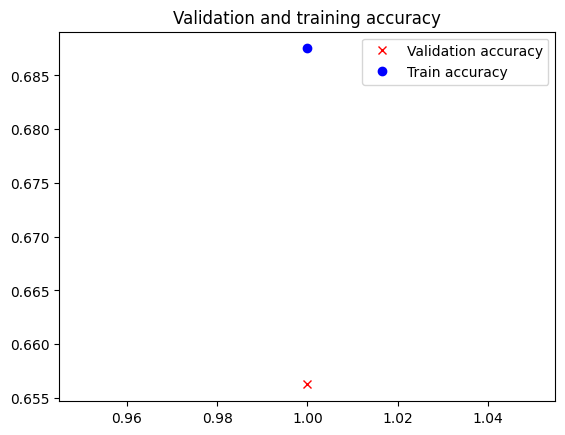

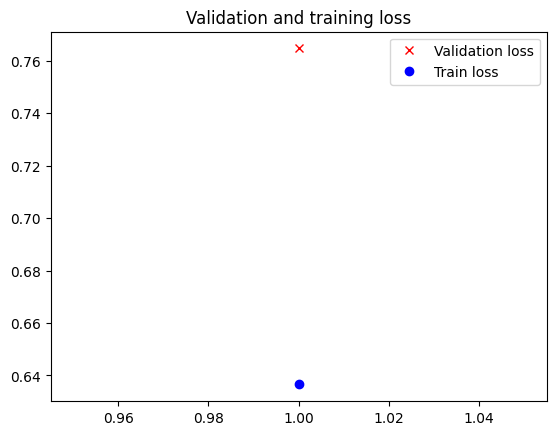

 10%|█         | 1/10 [00:48<07:17, 48.62s/it]

lr: 0.0001
2.328312873840332
[0.8973280191421509]


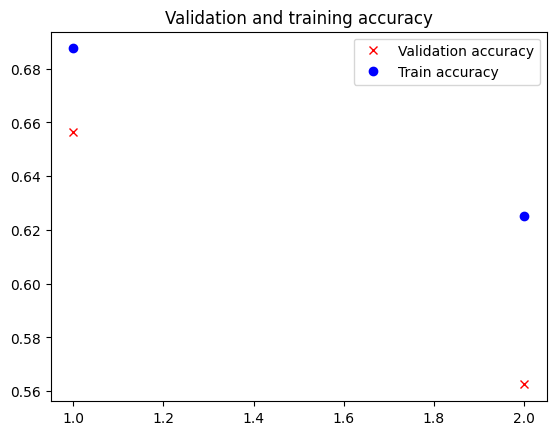

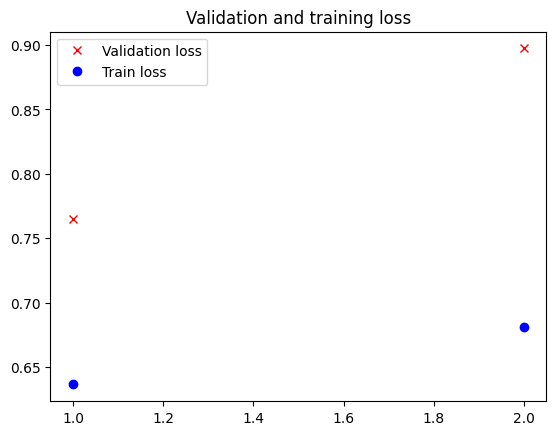

 20%|██        | 2/10 [01:37<06:30, 48.84s/it]

lr: 5.05e-05


 20%|██        | 2/10 [01:42<06:50, 51.25s/it]


KeyboardInterrupt: 

In [9]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR
import numpy as np

EPOCHS = 10
GRAD_ACC = 1
START_LR = 1e-4
END_LR = 1e-6
device="cpu"


optimizer = torch.optim.AdamW(model_cross.parameters(), lr=START_LR)
cos_scheduler = CosineAnnealingLR(optimizer, T_max=2, eta_min=END_LR)
warmup_scheduler = LinearLR(optimizer, start_factor=0.001, end_factor=1.0, total_iters=len(dataloader))

acc_train_history = []
acc_val_history = []
loss_train_history = []
loss_val_history = []
optimizer.zero_grad()
for epoch in tqdm(range(EPOCHS)):
    print(f"lr: {optimizer.param_groups[0]["lr"]}")
    max_grad = []
    acc_train = 0
    loss_train = 0
    j = 0
    grad_accumulation = GRAD_ACC
    model_cross.train()
    for i, (input_ids, attention_mask, y_batch) in enumerate(dataloader):
        tokens = {"input_ids": input_ids.to(device), "attention_mask": attention_mask.to(device)} #får inte till på nåt annat sätt
        y_batch = y_batch.to(device)
        y_pred = model_cross(**tokens)["logits"]
        loss = loss_fn(y_pred, y_batch.long())
        loss_train += loss.item()
        loss = loss/grad_accumulation
        loss.backward() #computes dloss/dx, gradient for all weights
        acc_train += torch.sum(y_batch == torch.argmax(y_pred, dim=-1))/y_batch.size()[0]
        j += 1
        if (i+1) % grad_accumulation==0 or i+1==len(dataloader):
            max_grad.append(np.max([p.grad.norm(2).item() for p in model_cross.parameters() if p.grad is not None]))
            optimizer.step() #uses stored gradient to update each weight
            optimizer.zero_grad()
            left = len(dataloader)-(i+1)
            if left < GRAD_ACC:
                grad_accumulation = left
        if epoch==0:
            warmup_scheduler.step()
    if epoch>0 and epoch<=2:
        cos_scheduler.step()
        #if epoch%3 == 0:
        #    optimizer.param_groups[0]["lr"] = START_LR
        #    cos_scheduler = CosineAnnealingLR(optimizer, T_max=2, eta_min=END_LR)
    elif epoch==3:
        optimizer.param_groups[0]["lr"] = END_LR

    print(np.max(max_grad))

    acc_train_history += [acc_train.to("cpu")/j] #dela med hur många batches, cpu för att kunna plotta, annars måste man göra det för varje tensor i listan senare
    loss_train_history += [loss_train/j]

    torch.save(model_cross, "cross_encoder_temp"+str(epoch)+".pt")

    model_cross.eval()
    with torch.no_grad():
        acc_val = 0
        loss_val = 0
        loss_check = []
        j = 0
        for input_ids, attention_mask, y_val in eval_dataloader: # batches för minne
            tokens = {"input_ids": input_ids.to(device), "attention_mask": attention_mask.to(device)} #får inte till på nåt annat sätt
            y_val = y_val.to(device)
            y_val_pred = model_cross(**tokens)["logits"]
            loss = loss_fn(y_val_pred, y_val.long())
            loss_val += loss.item()
            loss_check += [loss.item()]
            acc_val += torch.sum(y_val == torch.argmax(y_val_pred, dim=-1))/y_val.size()[0]
            j += 1
        acc_val_history += [acc_val.to("cpu")/j] #cpu för att kunna plotta, annars måste man göra det för varje tensor i listan senare, j för batches
        loss_val_history += [loss_val/j]
        print(loss_check)
    
    epochs = range(1, len(acc_train_history) + 1)
    plt.plot(epochs, acc_val_history, 'rx', label='Validation accuracy')
    plt.plot(epochs, acc_train_history, 'bo', label='Train accuracy')
    plt.title('Validation and training accuracy')
    plt.legend()
    plt.show()

    plt.plot(epochs, loss_val_history, 'rx', label='Validation loss')
    plt.plot(epochs, loss_train_history, 'bo', label='Train loss')
    plt.title('Validation and training loss')
    plt.legend()
    plt.show()
    


In [ ]:
from transformers import AutoConfig
config = AutoConfig.from_pretrained(model_name, trust_remote_code=True)
print(config)

config.unpad_inputs=False
config.use_memory_efficient_attention = False

NameError: name 'model_name' is not defined

In [ ]:
config.unpad_inputs=False
config.use_memory_efficient_attention = False

In [55]:
model_cross = AutoModel.from_pretrained(model_name, add_pooling_layer=False, trust_remote_code=True, config=config)

In [54]:
c = model.config
print(c)

GteConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "Snowflake/snowflake-arctic-embed-m-v2.0",
  "architectures": [
    "GteModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "auto_map": {
    "AutoConfig": "Snowflake/snowflake-arctic-embed-m-v2.0--configuration_hf_alibaba_nlp_gte.GteConfig",
    "AutoModel": "Snowflake/snowflake-arctic-embed-m-v2.0--modeling_hf_alibaba_nlp_gte.GteModel"
  },
  "classifier_dropout": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "layer_norm_type": "layer_norm",
  "logn_attention_clip1": false,
  "logn_attention_scale": false,
  "matryoshka_dimensions": [
    256
  ],
  "max_position_embeddings": 8192,
  "model_type": "gte",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pack_qkv": true,
  "pad_token_id": 1,
  "position_embedding_type": "rope",
  "rope_scaling": null,
  "rope_theta": 160000,
  "torch_d

In [34]:
loss_val_history

[0.3915537413089506,
 0.38623259721263764,
 0.40387623204338935,
 0.3817865374468027,
 0.3849769846626347,
 0.38432273469985495,
 0.3861742765312233,
 0.38703229254291904,
 0.3872996377908895,
 0.38785069111374115]

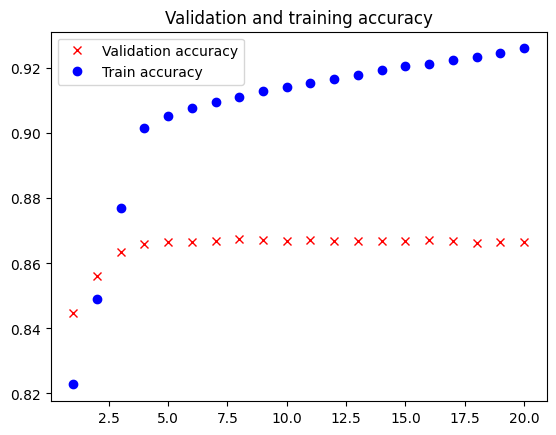

In [27]:
import matplotlib.pyplot as plt

epochs = range(1, len(acc_train_history) + 1)
plt.plot(epochs, acc_val_history, 'rx', label='Validation accuracy')
plt.plot(epochs, acc_train_history, 'bo', label='Train accuracy')
plt.title('Validation and training accuracy')
plt.legend()
ax = plt.gca()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(loss_train_history[:e]) + 1)
plt.plot(epochs, loss_val_history[:e], 'rx', label='Validation loss')
plt.plot(epochs, loss_train_history[:e], 'bo', label='Train loss')
plt.title('Validation and training loss')
plt.legend()
plt.show()

In [19]:
loss_val_history

[0.3936392244312071,
 0.34990688605654624,
 0.3434106192040828,
 0.3470049697545267,
 0.35447160190632265,
 0.3775322978655177,
 0.41684272044127985,
 0.41169171059323895,
 0.4452198054040632,
 0.47066555806105176,
 0.5505024852050889,
 0.556001782357212,
 0.657583836105562,
 0.6672811549036733,
 0.6428825935168613,
 0.668974912184621]

In [4]:
import torch
model_cross = torch.load("cross_encoder_temp3.pt", weights_only=False)

### Train with trainer

In [ ]:
from datasets import Dataset, load_from_disk

train_dataset = load_from_disk("train_dataset3")
train_dataset = train_dataset[:25000]
train_dataset = Dataset.from_dict(train_dataset).shuffle(seed=42)

In [ ]:
def tokenize_fcn(examples):
    return tokenizer(examples["data"], padding="max_length", truncation=True)

train_dataset_tokenized = train_dataset.map(tokenize_fcn, batched=True)
train_dataset_tokenized = train_dataset_tokenized.rename_column("label", "labels")
train_dataset_tokenized = train_dataset_tokenized.remove_columns("data")

In [8]:
# load tokenized datset
from datasets import load_from_disk
train_dataset_tokenized = load_from_disk("train_dataset_tokenized")

In [ ]:
train_dataset_tokenized

In [10]:
import gc
torch.cuda.empty_cache()
gc.collect()

825

In [9]:
from transformers import Trainer, TrainingArguments

#loss_fn = nn.CrossEntropyLoss()

training_args = TrainingArguments(
    output_dir = "crossencoder_temp",
    learning_rate = 1e-5,
    per_device_train_batch_size=16,
    num_train_epochs = 10,
    weight_decay = 0.01,
    gradient_accumulation_steps=1,
    #label_names = ["labels"],
    seed = 42
)

trainer = Trainer(
    model = model_cross,
    args = training_args,
    train_dataset = train_dataset_tokenized,
    #eval_dataset = eval_dataset,
    #processing_class = tokenizer,
    #data_collator = data_collator, ??
    #compute_loss_func= loss_fn
)

trainer.train()

Step,Training Loss


KeyboardInterrupt: 

### Rerank

In [85]:

corpus_text = corpus_ds["combined_text"] #fult men snabbare
corpus_pid = corpus_ds["product_id"]
query_text = query_test["query"]
query_qid = query_test["query_id"]

p_id_to_index = {p_id: idx for idx,p_id in enumerate(corpus_pid)}
q_id_to_index = {q_id: idx for idx,q_id in enumerate(query_qid)}

def pid_to_text(pid):
    return corpus_text[p_id_to_index[pid]]
                     
def qid_to_text(qid):
    return query_text[q_id_to_index[qid]]

In [53]:
# hjälper ibland om problem med cuda-minne
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
# create pairs
"""
top_100_labels_test = load_from_disk("top_100_labels_test.npy")
query_product_text = []
query_ids = top_100_labels_test["query_id"]
product_ids = top_100_labels_test["product_id"]
for q_id,p_id in zip(query_ids, product_ids):
    query_product_text.append([qid_to_text(q_id), pid_to_text(p_id)])
top_100_labels_test = top_100_labels_test.add_column("query_product_text", query_product_text)
"""

In [ ]:
# create smaller dataset for testing
"""
from datasets import Dataset
top_100_labels_test = top_100_labels_test.select(i for i in range(len(top_100_labels_test)) if i<1810000 and i%200000<10000)
top_100_labels_test = Dataset.from_dict(top_100_labels_test)
"""

Parameter 'indices'=<generator object <genexpr> at 0x7fc940ba79f0> of the transform datasets.arrow_dataset.Dataset.select couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [ ]:
from torch.utils.data import TensorDataset, DataLoader
from datasets import load_from_disk

top_100_labels_test = load_from_disk("test_top_100")
#top_100_labels_test = load_from_disk("test_top_100_nano")

test_tokens = tokenizer(top_100_labels_test["query_product_text"], padding=True, truncation=True, return_tensors="pt")
test_dataset = TensorDataset(test_tokens["input_ids"], test_tokens["attention_mask"])
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [10]:
model_cross.eval()
logits = []
with torch.no_grad():
    for input_ids, attention_mask in test_dataloader:
            tokens = {"input_ids": input_ids.to(device), "attention_mask": attention_mask.to(device)}
            outputs = model_cross(**tokens)
            logits.append(outputs["logits"].to("cpu"))
logits = torch.cat(logits)
soft = nn.Softmax(dim=-1)
scores = soft(logits)
rerank_scores = scores[:,1]

In [70]:
def map_score(y_true, y_pred, k):
    all_ap = []
    for i in range(len(y_true)):
        pred = np.array(y_pred[i], dtype='float32')
        true = np.array(y_true[i], dtype='float32')
        data_dict = {"pred" : pred, "true" : true}
        ds = Dataset.from_dict(data_dict)
        ds_sorted = ds.sort("pred", reverse=True)

        pred = ds_sorted["pred"]
        true = ds_sorted["true"]
        true_k = true[:k]
        if sum(true_k) == 0:
            app = 0
        else:
            ap = []
            for j in range(len(true_k)):
                p = (sum(true_k[:j+1])*true_k[j])/(j+1)

                ap.append(p)
        
            app = sum(ap)/sum(true_k)
        all_ap.append(app)

    mean_ap = sum(all_ap)/(i+1)
    return mean_ap

def map_at_k(top_100_labels : Dataset, k, top_k):
    y_true = []
    y_score = []
    score_row = []
    true_row = []
    for i in range(top_100_labels.num_rows):
        score_row.append(top_100_labels[i]["score"])
        true_row.append(top_100_labels[i]["label"])
        if (i+1) % top_k == 0:
            y_true.append(true_row)
            y_score.append(score_row)
            score_row = []
            true_row = []

    y_score = np.array(y_score)
    y_true = np.array(y_true)
    return map_score(y_true, y_score, k=k)

In [61]:
def mrr_score(y_true, y_pred, k):
    all_rr = []
    for i in range(len(y_true)):
        pred = np.array(y_pred[i], dtype='float32')
        true = np.array(y_true[i], dtype='float32')
        data_dict = {"pred" : pred, "true" : true}
        ds = Dataset.from_dict(data_dict)
        ds_sorted = ds.sort("pred", reverse=True)

        pred = ds_sorted["pred"]
        true = ds_sorted["true"]

        true_k = true[:k]
        try:
            rr = 1 / (true_k.index(1)+1)
        except ValueError:
            rr = 0
        all_rr.append(rr)

    mean_rr = sum(all_rr)/(i+1)
    return mean_rr


def mrr_at_k(top_100_labels : Dataset, k, top_k):
    y_true = []
    y_score = []
    score_row = []
    true_row = []
    for i in range(top_100_labels.num_rows):
        score_row.append(top_100_labels[i]["score"])
        true_row.append(top_100_labels[i]["label"])
        if (i+1) % top_k == 0:
            y_true.append(true_row)
            y_score.append(score_row)
            score_row = []
            true_row = []

    y_score = np.array(y_score)
    y_true = np.array(y_true)
    return mrr_score(y_true, y_score, k=k)

In [85]:
from datasets import load_from_disk
top_ds = load_from_disk("theca_top_ds_test")

In [86]:
temp_dataset = top_ds.remove_columns("score")
perfect = temp_dataset.add_column("score", temp_dataset["label"])

In [87]:
mrr = mrr_at_k(perfect, k=10, top_k=100)
print(f"MRR@10: {mrr}")

MRR@10: 0.6789199739752765


In [11]:
# print score
temp_dataset = top_100_labels_test.remove_columns("score")
test_dataset_labels_scores = temp_dataset.add_column("score", rerank_scores.tolist())

print(f"NDCG@10: {ndcg_at_k(test_dataset_labels_scores, k=10,top_k=100)}")

NDCG@10: 0.4782665636172819


In [ ]:
# print oracle score
temp_dataset = top_100_labels_test.remove_columns("score")
test_dataset_labels_perfect = temp_dataset.add_column("score", temp_dataset["label"])

print(f"NDCG@10: {ndcg_at_k(test_dataset_labels_perfect, k=10,top_k=100)}")

NDCG@10: 1.0


In [40]:
from datasets import Dataset
from sklearn.metrics import ndcg_score
import numpy as np

def ndcg_at_k(top_100_labels : Dataset, k, top_k):
    y_true = []
    y_score = []
    score_row = []
    true_row = []
    for i in range(top_100_labels.num_rows):
        score_row.append(top_100_labels[i]["score"])
        true_row.append(top_100_labels[i]["label"])
        if (i+1) % top_k == 0:
            y_true.append(true_row)
            y_score.append(score_row)
            score_row = []
            true_row = []

    y_score = np.array(y_score)
    y_true = np.array(y_true)
    return ndcg_score(y_true, y_score, k=k)

In [ ]:
from sklearn.metrics import recall_score

def recall_at_k(top_100_labels : Dataset, k, top_k):
    recall_scores = []
    for i in range(top_100_labels.num_rows / top_k):
        top_k_temp = top_100_labels[i*top_k:(i+1)*top_k]
        top_k_temp = Dataset.from_dict(top_k_temp)
        top_k_temp = top_k_temp.to_pandas()
        top_k_temp = top_k_temp.sort_values(by=['score'], ascending=[False])
        y_true = top_k_temp["label"]
        # can choose y_pred as all ones in top k and the rest zeroes, or just use labels and set zeroes after k, recall doesnt care about fp
        y_pred = np.zeros(top_k)
        y_pred[:k] = np.ones(k) 
        recall_scores += recall_score(y_true, y_pred)
        
    return sum(recall_scores)/len(recall_scores)

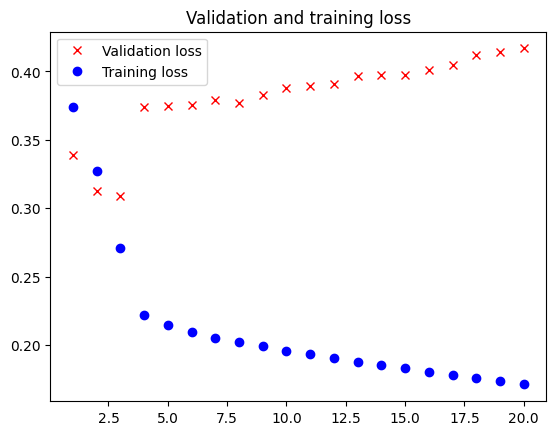

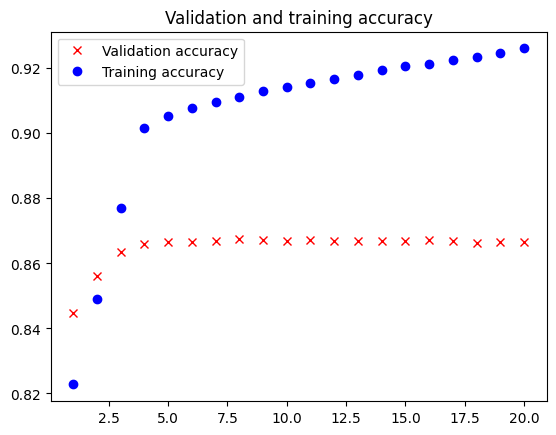

In [32]:
import numpy as np
import matplotlib.pyplot as plt
loss_val_history = np.load("FULL_train1/loss_val_history.npy")
acc_val_history = np.load("FULL_train1/acc_val_history.npy")
loss_train_history = np.load("FULL_train1/loss_train_history.npy")
acc_train_history = np.load("FULL_train1/acc_train_history.npy")

epochs = range(1, len(loss_val_history) + 1)
plt.plot(epochs, loss_val_history, 'rx', label='Validation loss')
plt.plot(epochs, loss_train_history, 'bo', label='Training loss')
plt.title('Validation and training loss')
plt.legend()
ax = plt.gca()
plt.show()

epochs = range(1, len(acc_val_history) + 1)
plt.plot(epochs, acc_val_history, 'rx', label='Validation accuracy')
plt.plot(epochs, acc_train_history, 'bo', label='Training accuracy')
plt.title('Validation and training accuracy')
plt.legend()
ax = plt.gca()
plt.show()

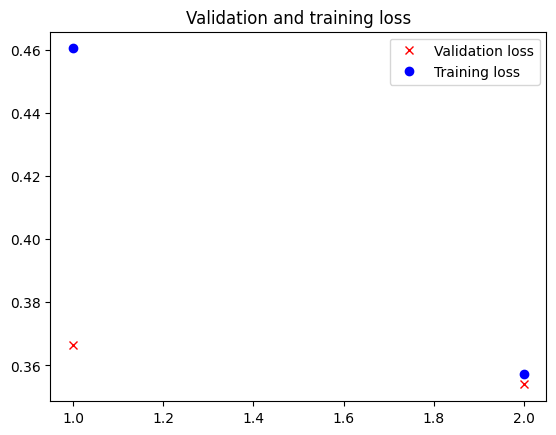

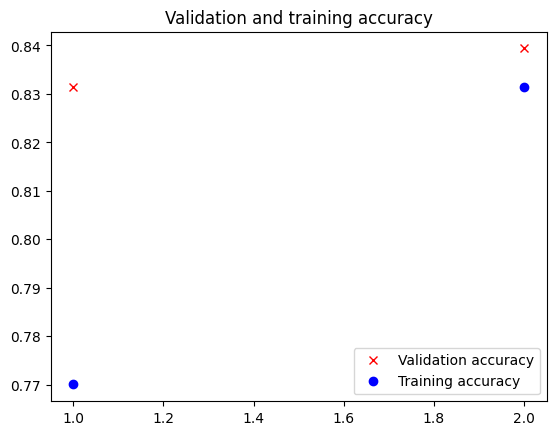

[0.36647257 0.35396822]
[0.8315071  0.83938426]


In [5]:
import numpy as np
import matplotlib.pyplot as plt
k = 0
loss_val_history = np.load("loss_val_history"+str(k)+"_11.npy")
acc_val_history = np.load("acc_val_history"+str(k)+"_11.npy")
loss_train_history = np.load("loss_train_history"+str(k)+"_11.npy")
acc_train_history = np.load("acc_train_history"+str(k)+"_11.npy")

epochs = range(1, len(loss_val_history) + 1)
plt.plot(epochs, loss_val_history, 'rx', label='Validation loss')
plt.plot(epochs, loss_train_history, 'bo', label='Training loss')
plt.title('Validation and training loss')
plt.legend()
ax = plt.gca()
plt.show()

epochs = range(1, len(acc_val_history) + 1)
plt.plot(epochs, acc_val_history, 'rx', label='Validation accuracy')
plt.plot(epochs, acc_train_history, 'bo', label='Training accuracy')
plt.title('Validation and training accuracy')
plt.legend()
ax = plt.gca()
plt.show()

print(loss_val_history)
print(acc_val_history)

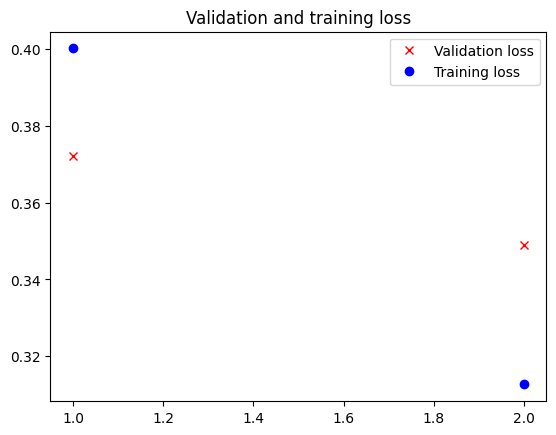

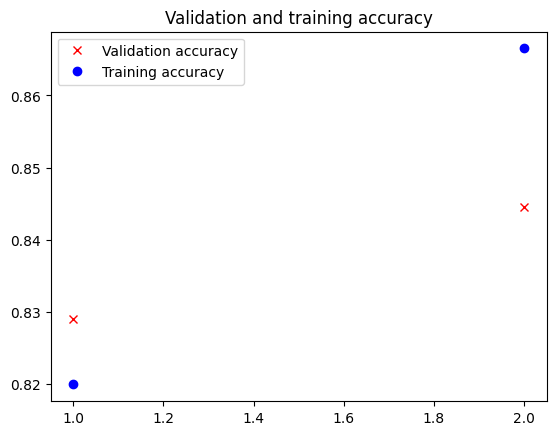

[0.37214696 0.34889364]
[0.8289441 0.8444632]


In [10]:
import numpy as np
import matplotlib.pyplot as plt
k = 0
loss_val_history = np.load("loss_val_history"+str(k)+"_12.npy")
acc_val_history = np.load("acc_val_history"+str(k)+"_12.npy")
loss_train_history = np.load("loss_train_history"+str(k)+"_12.npy")
acc_train_history = np.load("acc_train_history"+str(k)+"_12.npy")

epochs = range(1, len(loss_val_history) + 1)
plt.plot(epochs, loss_val_history, 'rx', label='Validation loss')
plt.plot(epochs, loss_train_history, 'bo', label='Training loss')
plt.title('Validation and training loss')
plt.legend()
ax = plt.gca()
plt.show()

epochs = range(1, len(acc_val_history) + 1)
plt.plot(epochs, acc_val_history, 'rx', label='Validation accuracy')
plt.plot(epochs, acc_train_history, 'bo', label='Training accuracy')
plt.title('Validation and training accuracy')
plt.legend()
ax = plt.gca()
plt.show()

print(loss_val_history)
print(acc_val_history)

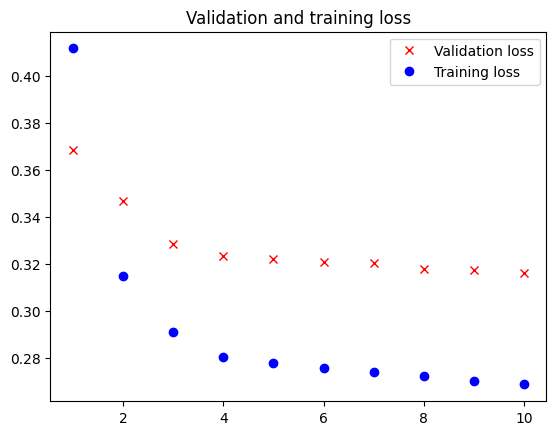

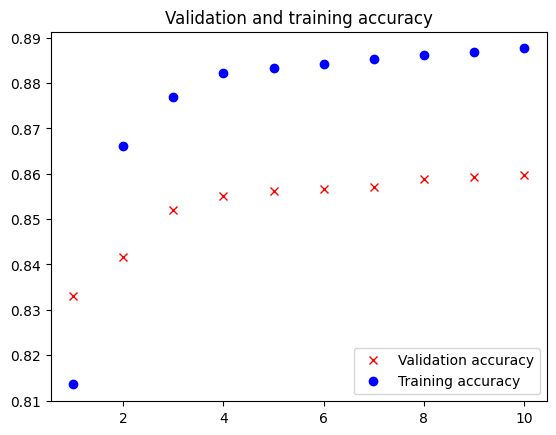

[0.36848091 0.34680352 0.32829798 0.32330829 0.32211358 0.32099827
 0.32049839 0.317873   0.3175062  0.31616128]
[0.832949   0.84171057 0.85198605 0.8551942  0.8561433  0.85670024
 0.85713166 0.85875535 0.8592181  0.859728  ]


In [ ]:
# 5 ENCODERS MED 1+2 POSITIVA OCH NEGATIVA 
import numpy as np
import matplotlib.pyplot as plt
k = 5
loss_val_history = np.load("training/loss_val_history_"+str(k)+".npy")
acc_val_history = np.load("training/acc_val_history_"+str(k)+".npy")
loss_train_history = np.load("training/loss_train_history_"+str(k)+".npy")
acc_train_history = np.load("training/acc_train_history_"+str(k)+".npy")

epochs = range(1, len(loss_val_history) + 1)
plt.plot(epochs, loss_val_history, 'rx', label='Validation loss')
plt.plot(epochs, loss_train_history, 'bo', label='Training loss')
plt.title('Validation and training loss')
plt.legend()
ax = plt.gca()
plt.show()

epochs = range(1, len(acc_val_history) + 1)
plt.plot(epochs, acc_val_history, 'rx', label='Validation accuracy')
plt.plot(epochs, acc_train_history, 'bo', label='Training accuracy')
plt.title('Validation and training accuracy')
plt.legend()
ax = plt.gca()
plt.show()

print(loss_val_history)
print(acc_val_history)

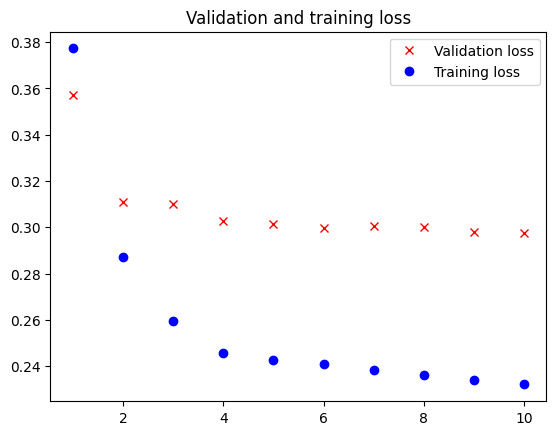

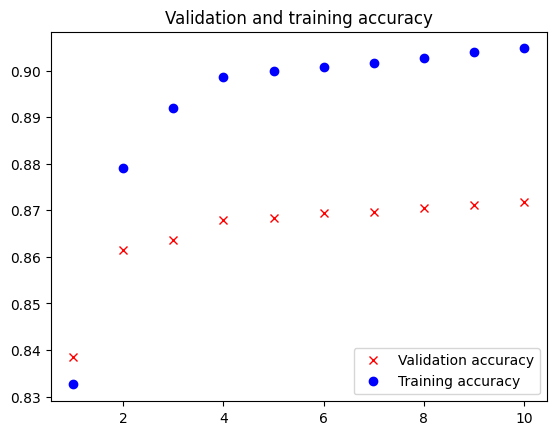

[0.35701865 0.31070687 0.31001189 0.30265129 0.30145731 0.29978685
 0.30040785 0.29996377 0.29805945 0.2974468 ]
[0.8384475  0.8613987  0.86362636 0.86790913 0.8684033  0.86948574
 0.8696426  0.87040347 0.87113297 0.8717605 ]


In [ ]:
# 8 ENCODERS MED 1+2 POSITIVA OCH NEGATIVA 
import numpy as np
import matplotlib.pyplot as plt
k = 8
loss_val_history = np.load("training/loss_val_history_"+str(k)+".npy")
acc_val_history = np.load("training/acc_val_history_"+str(k)+".npy")
loss_train_history = np.load("training/loss_train_history_"+str(k)+".npy")
acc_train_history = np.load("training/acc_train_history_"+str(k)+".npy")

ndcgk = np.load("ndcgk.npy")
mapk = np.load("mapk.npy")
mrrk = np.load("mrrk.npy")

epochs = range(1, len(loss_val_history) + 1)
plt.plot(epochs, loss_val_history, 'rx', label='Validation loss')
plt.plot(epochs, loss_train_history, 'bo', label='Training loss')
plt.plot(epochs, ndcgk, 'g*', label='ndcg')
plt.title('Validation and training loss')
plt.legend()
ax = plt.gca()
plt.show()

epochs = range(1, len(acc_val_history) + 1)
plt.plot(epochs, acc_val_history, 'rx', label='Validation accuracy')
plt.plot(epochs, acc_train_history, 'bo', label='Training accuracy')
plt.plot(epochs, ndcgk, 'g*', label='ndcg')
plt.title('Validation and training accuracy')
plt.legend()
ax = plt.gca()
plt.show()

print(loss_val_history)
print(acc_val_history)

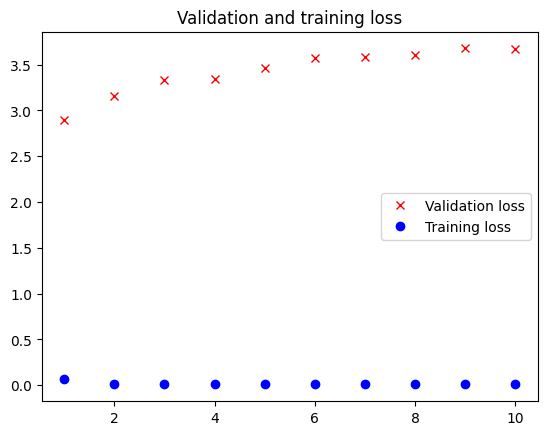

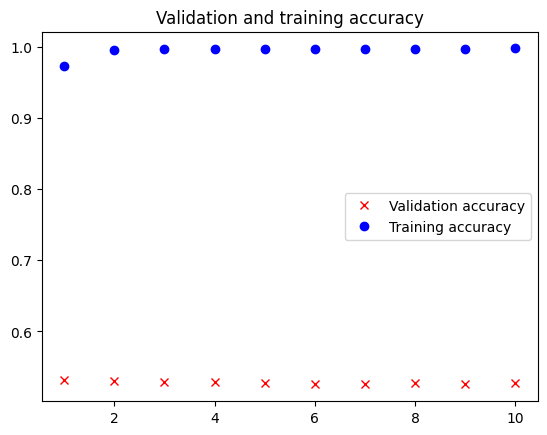

[2.90046728 3.15591313 3.33106797 3.34397432 3.46443432 3.57008087
 3.5878107  3.60884749 3.67657396 3.67504341]
[0.5318226  0.5299714  0.5284419  0.52917135 0.5271555  0.52577496
 0.5254377  0.5268731  0.5255946  0.52714765]


In [8]:
# 5 ENCODERS MED RANDOM NEGATIVA 
import numpy as np
import matplotlib.pyplot as plt
k = 5
loss_val_history = np.load("training/loss_val_history_"+str(k)+"rand.npy")
acc_val_history = np.load("training/acc_val_history_"+str(k)+"rand.npy")
loss_train_history = np.load("training/loss_train_history_"+str(k)+"rand.npy")
acc_train_history = np.load("training/acc_train_history_"+str(k)+"rand.npy")

epochs = range(1, len(loss_val_history) + 1)
plt.plot(epochs, loss_val_history, 'rx', label='Validation loss')
plt.plot(epochs, loss_train_history, 'bo', label='Training loss')
plt.title('Validation and training loss')
plt.legend()
ax = plt.gca()
plt.show()

epochs = range(1, len(acc_val_history) + 1)
plt.plot(epochs, acc_val_history, 'rx', label='Validation accuracy')
plt.plot(epochs, acc_train_history, 'bo', label='Training accuracy')
plt.title('Validation and training accuracy')
plt.legend()
ax = plt.gca()
plt.show()

print(loss_val_history)
print(acc_val_history)

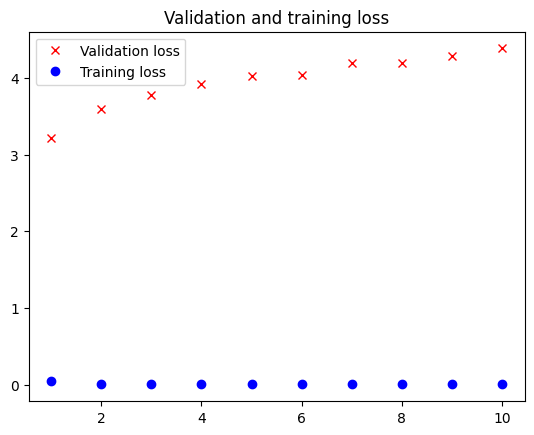

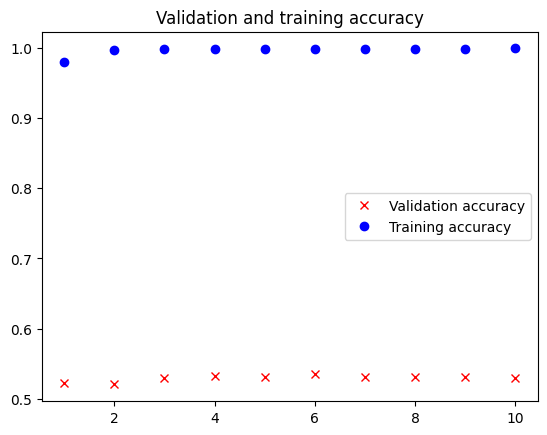

[3.21918053 3.59472086 3.7802834  3.91699192 4.01711764 4.03418063
 4.19841109 4.19120816 4.28226643 4.38127711]
[0.5226845  0.5207784  0.5301205  0.5328737  0.5313441  0.5350935
 0.5308107  0.53125    0.53093624 0.53034794]


In [9]:
# 5 ENCODERS MED RANDOM NEGATIVA 
import numpy as np
import matplotlib.pyplot as plt
k = 8
loss_val_history = np.load("training/loss_val_history_"+str(k)+"rand.npy")
acc_val_history = np.load("training/acc_val_history_"+str(k)+"rand.npy")
loss_train_history = np.load("training/loss_train_history_"+str(k)+"rand.npy")
acc_train_history = np.load("training/acc_train_history_"+str(k)+"rand.npy")

epochs = range(1, len(loss_val_history) + 1)
plt.plot(epochs, loss_val_history, 'rx', label='Validation loss')
plt.plot(epochs, loss_train_history, 'bo', label='Training loss')
plt.title('Validation and training loss')
plt.legend()
ax = plt.gca()
plt.show()

epochs = range(1, len(acc_val_history) + 1)
plt.plot(epochs, acc_val_history, 'rx', label='Validation accuracy')
plt.plot(epochs, acc_train_history, 'bo', label='Training accuracy')
plt.title('Validation and training accuracy')
plt.legend()
ax = plt.gca()
plt.show()

print(loss_val_history)
print(acc_val_history)

In [2]:
import numpy as np
acc_val = np.load("acc_val_history"+0+"_11.npy")
acc_val2 = np.load("acc_val_history"+1+"_11.npy")
acc_val - acc_val2

TypeError: can only concatenate str (not "int") to str

In [ ]:
mean_loss_11 = []
for k in range(5):
    acc_val = np.load("acc_val_history"+str(k)+"_11.npy")
    mean_

In [10]:
import torch
model_temp = torch.load("cross_encoder_temp19.pt", weights_only=False)
torch.save(model_temp, "pretrained_crossencoder.pt")

In [17]:
loss_val_history

array([0.34061973, 0.31641011, 0.30230124, 0.30071958])

In [25]:
acc_val_history

array([0.510016  , 0.52884614, 0.5344551 , 0.5500801 , 0.56209934,
       0.5641026 , 0.5761218 , 0.58092946, 0.5849359 , 0.5897436 ,
       0.5917468 , 0.59415066, 0.59615386, 0.5985577 , 0.59975964,
       0.6005609 , 0.60176283, 0.5977564 , 0.60216343, 0.60016024],
      dtype=float32)

In [73]:
loss_val_history

array([0.24532903, 0.25009295, 0.23111653, 0.22838436, 0.22678521])

In [90]:
from datasets import load_from_disk, concatenate_datasets
import random

ds = load_from_disk("full_TEST")
q_idx = random.sample(range(len(ds)//100),100)
ds_list = []
for idx in q_idx:
    ds_list.append(ds.select(range(idx*100,(idx+1)*100)))

queries100_test = concatenate_datasets(ds_list)


In [93]:
diffs = np.load("mean_diffs.npy")
diffs

array([0.14694434, 0.3254321 , 0.3464122 , 0.35127658, 0.35236695],
      dtype=float32)

In [95]:
diff = np.load("mean_diff_untrained.npy")
diff

array([0.14675786], dtype=float32)

In [154]:
scores_untrained = np.load("untrained_scores.npy")
sum(scores_untrained)/len(scores_untrained)

np.float32(0.5353827)

In [187]:
i=4

In [188]:
scores_untrained[i*100:(i+1)*100]

array([0.4973182 , 0.49915215, 0.5608865 , 0.4985144 , 0.5385064 ,
       0.5209652 , 0.66098213, 0.6111313 , 0.60775274, 0.69858277,
       0.56366885, 0.4194431 , 0.53938454, 0.7072651 , 0.5301987 ,
       0.57503575, 0.566423  , 0.62107444, 0.69185334, 0.664842  ,
       0.6204965 , 0.3828877 , 0.54993767, 0.5360233 , 0.60438985,
       0.63969904, 0.62420464, 0.7236037 , 0.6570896 , 0.43804118,
       0.5203345 , 0.56112015, 0.41582832, 0.4671826 , 0.5096757 ,
       0.48192173, 0.6262553 , 0.50181514, 0.60757244, 0.722371  ,
       0.5632346 , 0.47235683, 0.5879053 , 0.5468515 , 0.40502718,
       0.6818923 , 0.4038794 , 0.59574354, 0.44575235, 0.53692937,
       0.50088626, 0.50553924, 0.39631364, 0.47376153, 0.681259  ,
       0.43944225, 0.45647752, 0.3978676 , 0.59718215, 0.57245   ,
       0.5192457 , 0.7743072 , 0.51310533, 0.4795866 , 0.7553125 ,
       0.6669902 , 0.69055057, 0.6638508 , 0.5643354 , 0.6444787 ,
       0.38108155, 0.5496515 , 0.47663012, 0.38668644, 0.47826

In [203]:
scores = np.load("rerank_scores1.npy")
sum(scores)/len(scores)

np.float32(0.27413478)

In [204]:
scores[i*100:(i+1)*100]

array([0.99917114, 0.99918073, 0.97559834, 0.95519704, 0.9474278 ,
       0.3945363 , 0.01924548, 0.20713711, 0.21918847, 0.11962134,
       0.03459275, 0.01235535, 0.00912165, 0.0040874 , 0.01487269,
       0.00590749, 0.0078027 , 0.01391412, 0.00416023, 0.04294432,
       0.02483967, 0.06147921, 0.00809177, 0.01954365, 0.00893642,
       0.00966023, 0.01632385, 0.01648577, 0.00435818, 0.02797275,
       0.0067858 , 0.00974549, 0.00471474, 0.02118254, 0.01287356,
       0.07819951, 0.00520262, 0.01217465, 0.01367686, 0.00421899,
       0.01356668, 0.01327153, 0.02465196, 0.0211599 , 0.0145658 ,
       0.00769277, 0.00564212, 0.01483193, 0.0176369 , 0.01188583,
       0.00799727, 0.01147483, 0.01255348, 0.01264826, 0.00869361,
       0.00491932, 0.04152443, 0.01999024, 0.00519072, 0.01378571,
       0.07019727, 0.01322618, 0.01510457, 0.01301515, 0.01767823,
       0.00876439, 0.03467011, 0.00596345, 0.01101474, 0.03009434,
       0.00328301, 0.01450033, 0.01754352, 0.0099786 , 0.01625

In [98]:
top_100_labels_test = load_from_disk("100_queries_test")

In [193]:
top_100_labels_test["score"][i*100:(i+1)*100]

[0.6657772064208984,
 0.6596640348434448,
 0.6161401867866516,
 0.5614233613014221,
 0.5561187267303467,
 0.5234333276748657,
 0.4743083119392395,
 0.4613339304924011,
 0.44142428040504456,
 0.42622968554496765,
 0.4256380796432495,
 0.42471858859062195,
 0.4222329258918762,
 0.42174673080444336,
 0.42114537954330444,
 0.41901087760925293,
 0.4176459014415741,
 0.4164397418498993,
 0.41594362258911133,
 0.41571223735809326,
 0.4152989685535431,
 0.41510096192359924,
 0.4140491783618927,
 0.40863609313964844,
 0.40796470642089844,
 0.40362441539764404,
 0.403178334236145,
 0.40253952145576477,
 0.4021608233451843,
 0.400732159614563,
 0.3998356759548187,
 0.39962413907051086,
 0.39885425567626953,
 0.39884984493255615,
 0.39839795231819153,
 0.3983040153980255,
 0.39734676480293274,
 0.3958383798599243,
 0.39495226740837097,
 0.3947586715221405,
 0.3936891257762909,
 0.3934546113014221,
 0.39339691400527954,
 0.39313822984695435,
 0.39281314611434937,
 0.3919062614440918,
 0.39149236679

In [194]:
top_100_labels_test["label"][i*100:(i+1)*100]

[0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [148]:
retrieval_scores = top_100_labels_test["score"]
sum(retrieval_scores)/len(retrieval_scores)

0.5008467655986547

In [205]:
test_ds = load_from_disk("full_TRAIN12")
test_ds

Dataset({
    features: ['data', 'label'],
    num_rows: 1531308
})

In [210]:
test_ds = load_from_disk("new_training/medium_TRAIN14")
test_ds

Dataset({
    features: ['data', 'label'],
    num_rows: 510430
})

In [21]:
import numpy as np
t = np.zeros(3)
t

array([0., 0., 0.])

In [22]:
t2 = np.array([1,2,3])
t2

array([1, 2, 3])

In [25]:
t += t2
t

array([2., 4., 6.])

In [28]:
t = t/2
t

array([0.25, 0.5 , 0.75])

In [5]:
import numpy as np
prestring = "msmarco"
a = np.load("rand_mean_scores_"+prestring+".npy")
a

array([0.04251723, 0.02754437, 0.0274374 ])

In [1]:
from datasets import concatenate_datasets
from datasets import load_from_disk
a = load_from_disk("theca_TRAIN12_random")
b = load_from_disk("amazon_TRAIN12_random")
c = load_from_disk("msmarco_TRAIN12_random")

full = concatenate_datasets([a,b,c])
full.save_to_disk("full_TRAIN12_random")


Saving the dataset (0/2 shards):   0%|          | 0/1531308 [00:00<?, ? examples/s]

In [2]:
full

Dataset({
    features: ['data', 'label'],
    num_rows: 1531308
})